Δ max: 1.00, min: 0.00, mean: 0.05
Pixels changed (above threshold): 9148


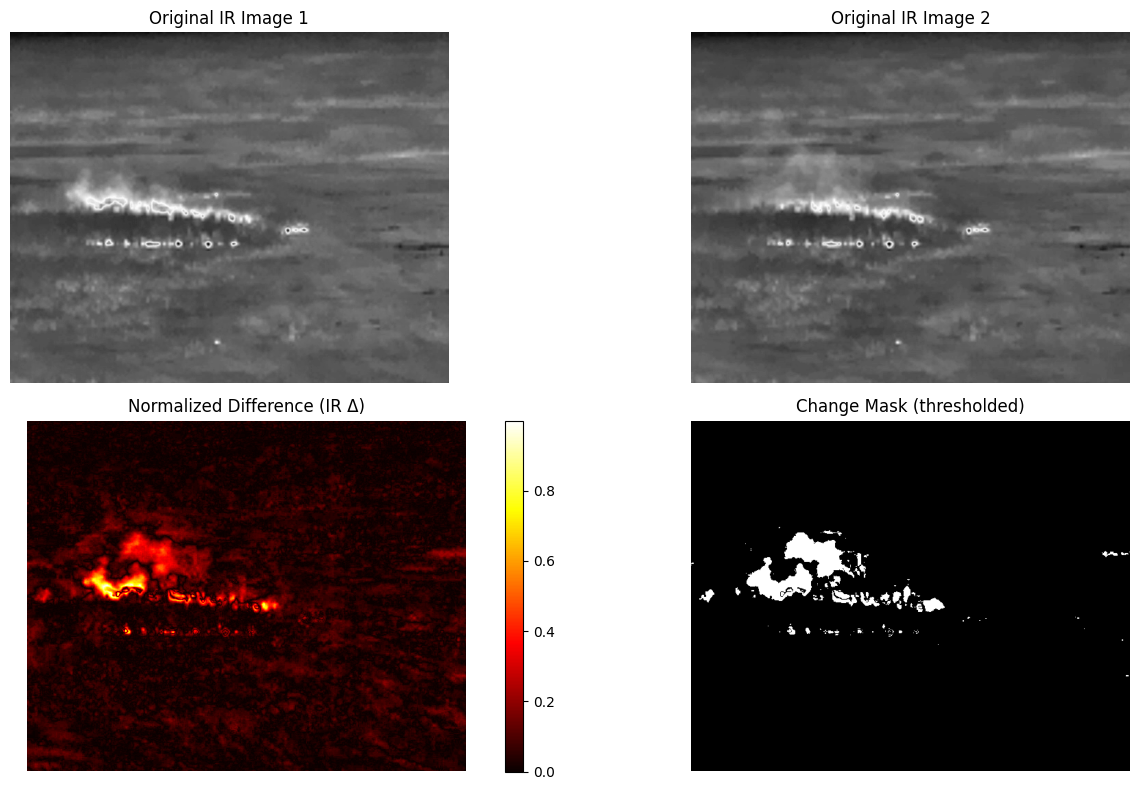

In [11]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_ir_difference(image1, image2, blur_kernel=0, threshold=None, normalize=False):
    # Convert to float for accurate processing
    img1 = image1.astype(np.float32)
    img2 = image2.astype(np.float32)

    # Optional Gaussian blur to reduce noise
    if blur_kernel > 0:
        img1 = cv2.GaussianBlur(img1, (blur_kernel, blur_kernel), 0)
        img2 = cv2.GaussianBlur(img2, (blur_kernel, blur_kernel), 0)

    # Compute absolute difference
    diff = np.abs(img1 - img2)

    # Optional normalization to [0, 1]
    if normalize:
        diff = (diff - diff.min()) / (diff.max() - diff.min() + 1e-5)

    # Optional thresholding to create binary change mask
    if threshold is not None:
        change_mask = diff > threshold
        return diff, change_mask.astype(np.uint8)

    return diff, None

def load_first_two_images_from_folder(folder_path, prefix="frame_val_mm_fire_"):
    files = sorted([
        f for f in os.listdir(folder_path)
        if f.startswith(prefix)
    ])
    if len(files) < 2:
        raise ValueError("Not enough images in folder.")
    
    img1_path = os.path.join(folder_path, files[0])
    img2_path = os.path.join(folder_path, files[1])

    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

    if img1 is None or img2 is None:
        raise ValueError("Could not load one or both images.")

    return img1, img2

# Path to the IR image folder
folder = r"C:\Projects\Flame2\Datasets_FromDvir\Datasets\FireMan\Fire\dji_video_004\dji_video_004_thermal"

# Load first two images
image1, image2 = load_first_two_images_from_folder(folder)

# Compute difference and binary change mask
diff, mask = compute_ir_difference(image1, image2, blur_kernel=0, threshold=0.2, normalize=True)

# Show basic stats
print(f"Δ max: {diff.max():.2f}, min: {diff.min():.2f}, mean: {diff.mean():.2f}")
if mask is not None:
    print(f"Pixels changed (above threshold): {np.sum(mask)}")

# Visualization
plt.figure(figsize=(15, 8))

# Original image 1
plt.subplot(2, 2, 1)
plt.title("Original IR Image 1")
plt.imshow(image1, cmap='gray')
plt.axis('off')

# Original image 2
plt.subplot(2, 2, 2)
plt.title("Original IR Image 2")
plt.imshow(image2, cmap='gray')
plt.axis('off')

# Difference heatmap
plt.subplot(2, 2, 3)
plt.title("Normalized Difference (IR Δ)")
plt.imshow(diff, cmap='hot')
plt.colorbar()
plt.axis('off')

# Thresholded change mask
if mask is not None:
    plt.subplot(2, 2, 4)
    plt.title("Change Mask (thresholded)")
    plt.imshow(mask, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()


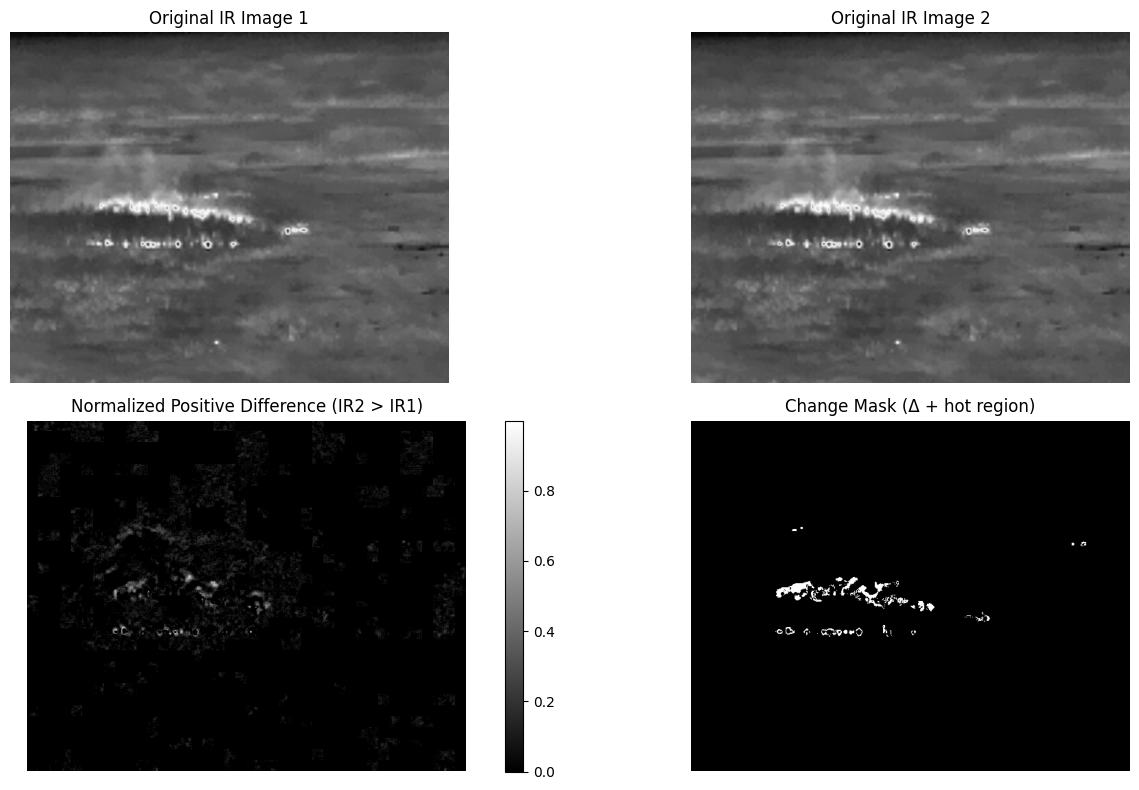

Δ max: 29.00, min: 0.00, mean: 0.38
Pixels changed (mask sum): 2538


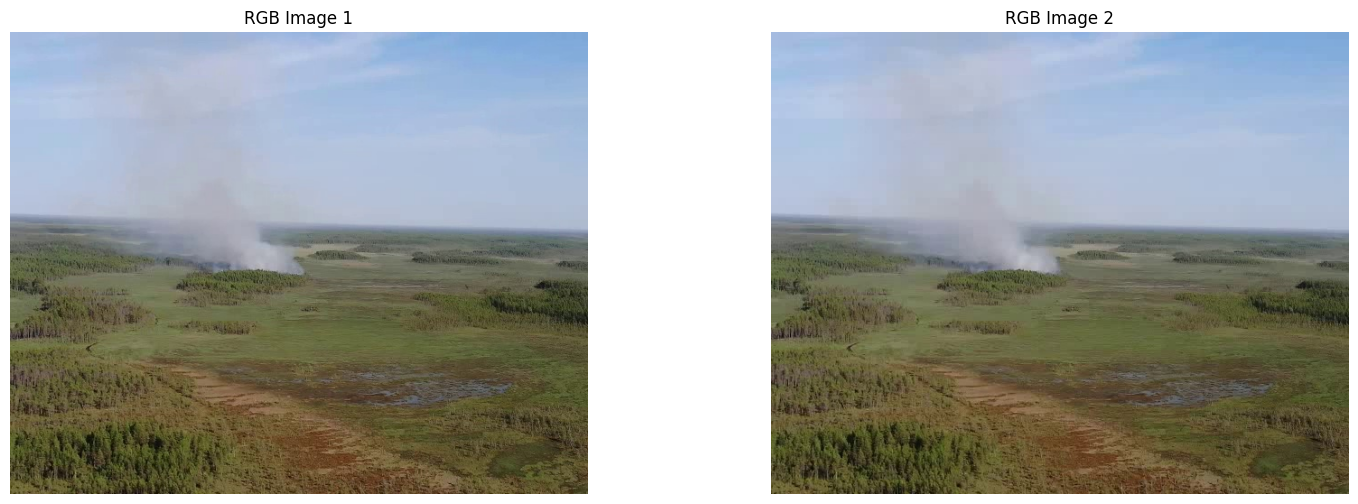

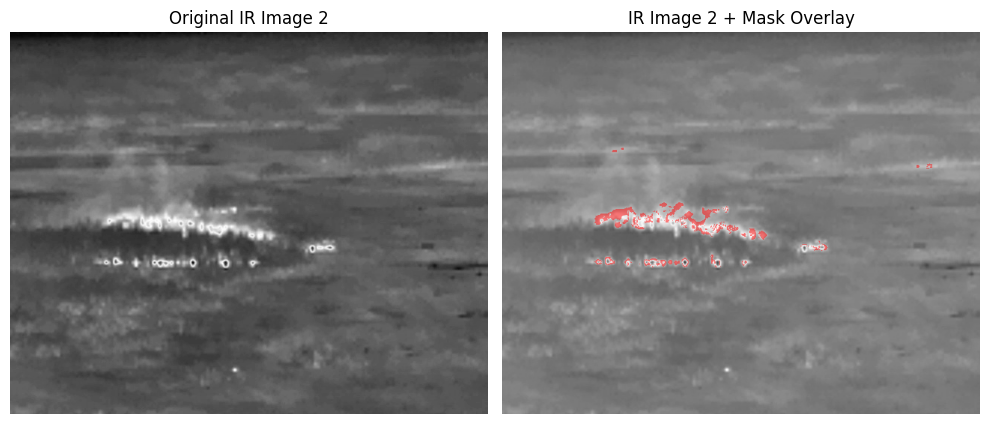

In [28]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_first_two_images_from_folder(folder_path, prefix="frame_val_mm_fire_"):
    files = sorted([
        f for f in os.listdir(folder_path)
        if f.startswith(prefix)
    ])
    if len(files) < 2:
        raise ValueError("Not enough images in folder.")
    
    img1_path = os.path.join(folder_path, files[5])
    img2_path = os.path.join(folder_path, files[5+1])

    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

    if img1 is None or img2 is None:
        raise ValueError("Could not load one or both images.")

    return img1, img2

def load_first_two_rgb_images(folder_path, filenames):
    img1_path = os.path.join(folder_path, filenames[0])
    img2_path = os.path.join(folder_path, filenames[1])

    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)

    if img1 is None or img2 is None:
        raise ValueError("Could not load one or both RGB images.")

    img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    return img1_rgb, img2_rgb


def preprocess_images(image1, image2, blur_kernel=0):
    img1 = image1.astype(np.float32)
    img2 = image2.astype(np.float32)

    if blur_kernel > 0:
        img1 = cv2.GaussianBlur(img1, (blur_kernel, blur_kernel), 0)
        img2 = cv2.GaussianBlur(img2, (blur_kernel, blur_kernel), 0)

    return img1, img2

def compute_positive_difference(img1, img2):
    diff = img2 - img1
    diff[diff < 0] = 0
    return diff

def postprocess_difference_map(diff, img2, threshold=None, temp_threshold=None):
    mask = np.ones_like(diff, dtype=bool)

    if threshold is not None:
        mask = np.logical_and(mask, diff > threshold)

    if temp_threshold is not None:
        temp_mask = img2 > (img2.mean() + temp_threshold)
        mask = np.logical_and(mask, temp_mask)

    return mask.astype(np.uint8)

def overlay_mask_on_rgb(image_rgb, mask, color=(255, 0, 0), alpha=0.5):
    overlay = image_rgb.copy().astype(np.float32)
    mask = mask.astype(bool)

    overlay[mask] = (1 - alpha) * overlay[mask] + alpha * np.array(color, dtype=np.float32)
    return np.clip(overlay, 0, 255).astype(np.uint8)


def overlay_mask_on_gray(image_gray, mask, color=(255, 0, 0), alpha=0.5):
    # Convert grayscale to RGB
    image_rgb = np.stack([image_gray]*3, axis=-1).astype(np.float32)
    mask = mask.astype(bool)

    # Apply red overlay where mask is True
    image_rgb[mask] = (1 - alpha) * image_rgb[mask] + alpha * np.array(color, dtype=np.float32)
    return np.clip(image_rgb, 0, 255).astype(np.uint8)


def visualize_results(image1, image2, diff, mask):
    plt.figure(figsize=(15, 8))

    plt.subplot(2, 2, 1)
    plt.title("Original IR Image 1")
    plt.imshow(image1, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.title("Original IR Image 2")
    plt.imshow(image2, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.title("Normalized Positive Difference (IR2 > IR1)")
    norm_diff = (diff - diff.min()) / (diff.max() - diff.min() + 1e-5)
    plt.imshow(norm_diff, cmap='gray')
    plt.colorbar()
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.title("Change Mask (Δ + hot region)")
    plt.imshow(mask, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()



# Path to folder
folder = r"C:\Projects\Flame2\Datasets_FromDvir\Datasets\FireMan\Fire\dji_video_004\dji_video_004_thermal"

# 1. Load
image1, image2 = load_first_two_images_from_folder(folder)

# 2. Preprocess
img1, img2 = preprocess_images(image1, image2, blur_kernel=0)

# 3. Compute difference (only positive changes)
diff = compute_positive_difference(img1, img2)

# 4. Filter mask
mask = postprocess_difference_map(diff, img2, threshold=1, temp_threshold=50)

# 5. Visualize
visualize_results(image1, image2, diff, mask)

# Optional stats
print(f"Δ max: {diff.max():.2f}, min: {diff.min():.2f}, mean: {diff.mean():.2f}")
print(f"Pixels changed (mask sum): {np.sum(mask)}")


# 6. Load matching RGB images using the same filenames
thermal_filenames = sorted([
    f for f in os.listdir(folder)
    if f.startswith("frame_val_mm_fire_")
])
rgb_folder = r"C:\Projects\Flame2\Datasets_FromDvir\Datasets\FireMan\Fire\dji_video_004\dji_video_004_rgb"
rgb1, rgb2 = load_first_two_rgb_images(rgb_folder, thermal_filenames)

# 7. Overlay mask on RGB image 2
rgb2_overlay = overlay_mask_on_rgb(rgb2, mask, color=(255, 0, 0), alpha=0.5)

# 8. Visualize RGB images and overlay
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.title("RGB Image 1")
plt.imshow(rgb1)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("RGB Image 2")
plt.imshow(rgb2)
plt.axis('off')


# 9. Overlay mask on IR image 2
image2_overlay = overlay_mask_on_gray(image2, mask, color=(255, 0, 0), alpha=0.5)

# 10. Visualize IR with overlay
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original IR Image 2")
plt.imshow(image2, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("IR Image 2 + Mask Overlay")
plt.imshow(image2_overlay)
plt.axis('off')

plt.tight_layout()
plt.show()



In [17]:
print("Min:", image1.min(), "Max:", image1.max(), "Mean:", image1.mean())
print("Min:", image2.min(), "Max:", image2.max(), "Mean:", image2.mean())
print("Min:", diff.min(), "Max:", diff.max(), "Mean:", diff.mean())


Min: 48 Max: 255 Mean: 125.2509033203125
Min: 51 Max: 255 Mean: 124.62606506347656
Min: 0.0 Max: 82.0 Mean: 1.9344238


In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def suppress_fire_regions_naive(image, fire_threshold=50):
    fire_mask = image > (image.mean() + fire_threshold)
    suppressed = image.copy()
    suppressed[fire_mask] = image.mean()
    return suppressed, fire_mask.astype(np.uint8)

def suppress_fire_regions_with_blur(image, fire_threshold=50, blur_kernel=31):
    fire_mask = image > (image.mean() + fire_threshold)
    blurred = cv2.GaussianBlur(image, (blur_kernel, blur_kernel), 0)
    suppressed = image.copy()
    suppressed[fire_mask] = blurred[fire_mask]
    return suppressed, fire_mask.astype(np.uint8)

def suppress_fire_regions_strong(image, fire_threshold=50, blur_kernel=31, intensity_scale=0.6):
    fire_mask = image > (image.mean() + fire_threshold)
    blurred = cv2.GaussianBlur(image, (blur_kernel, blur_kernel), 0)
    suppressed = image.copy().astype(np.float32)
    suppressed[fire_mask] = (
        (1 - intensity_scale) * image[fire_mask] + intensity_scale * blurred[fire_mask]
    )
    return np.clip(suppressed, 0, 255).astype(np.uint8), fire_mask.astype(np.uint8)

def compute_positive_difference(img1, img2):
    diff = img2 - img1
    diff[diff < 0] = 0
    return diff

def normalize_image(image):
    return (image - image.min()) / (image.max() - image.min() + 1e-5)


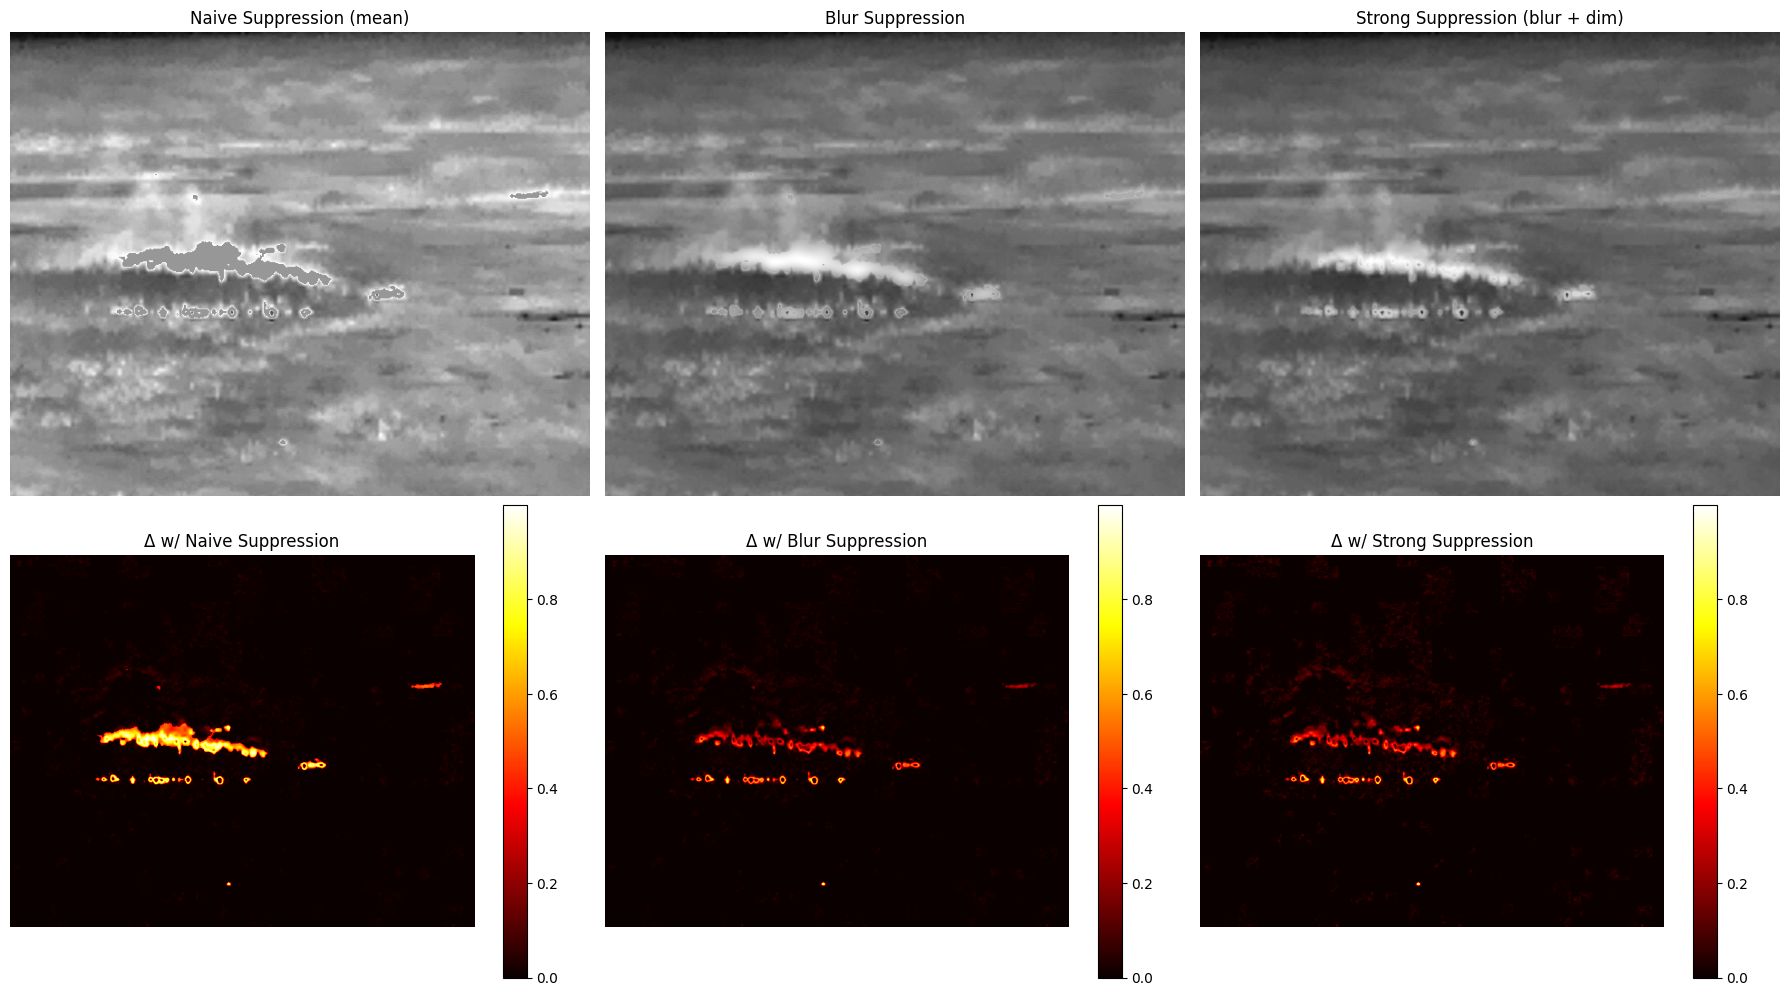

In [39]:
# נניח שכבר טענת img1 (IR image 1) ו־img2 (IR image 2) שניהם float32

# suppression methods
img1_naive, _ = suppress_fire_regions_naive(img1, fire_threshold=50)
img1_blur, _ = suppress_fire_regions_with_blur(img1, fire_threshold=50, blur_kernel=41)
img1_strong, _ = suppress_fire_regions_strong(img1, fire_threshold=50, blur_kernel=41, intensity_scale=0.6)

# differences
diff_naive = compute_positive_difference(img1_naive, img2)
diff_blur = compute_positive_difference(img1_blur, img2)
diff_strong = compute_positive_difference(img1_strong, img2)

# normalization for display
norm_naive = normalize_image(diff_naive)
norm_blur = normalize_image(diff_blur)
norm_strong = normalize_image(diff_strong)

# Visualization
plt.figure(figsize=(18, 10))

# Row 1 – Suppressed images
plt.subplot(2, 3, 1)
plt.title("Naive Suppression (mean)")
plt.imshow(img1_naive, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.title("Blur Suppression")
plt.imshow(img1_blur, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.title("Strong Suppression (blur + dim)")
plt.imshow(img1_strong, cmap='gray')
plt.axis('off')

# Row 2 – Corresponding difference maps
plt.subplot(2, 3, 4)
plt.title("Δ w/ Naive Suppression")
plt.imshow(norm_naive, cmap='hot')
plt.colorbar()
plt.axis('off')

plt.subplot(2, 3, 5)
plt.title("Δ w/ Blur Suppression")
plt.imshow(norm_blur, cmap='hot')
plt.colorbar()
plt.axis('off')

plt.subplot(2, 3, 6)
plt.title("Δ w/ Strong Suppression")
plt.imshow(norm_strong, cmap='hot')
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()


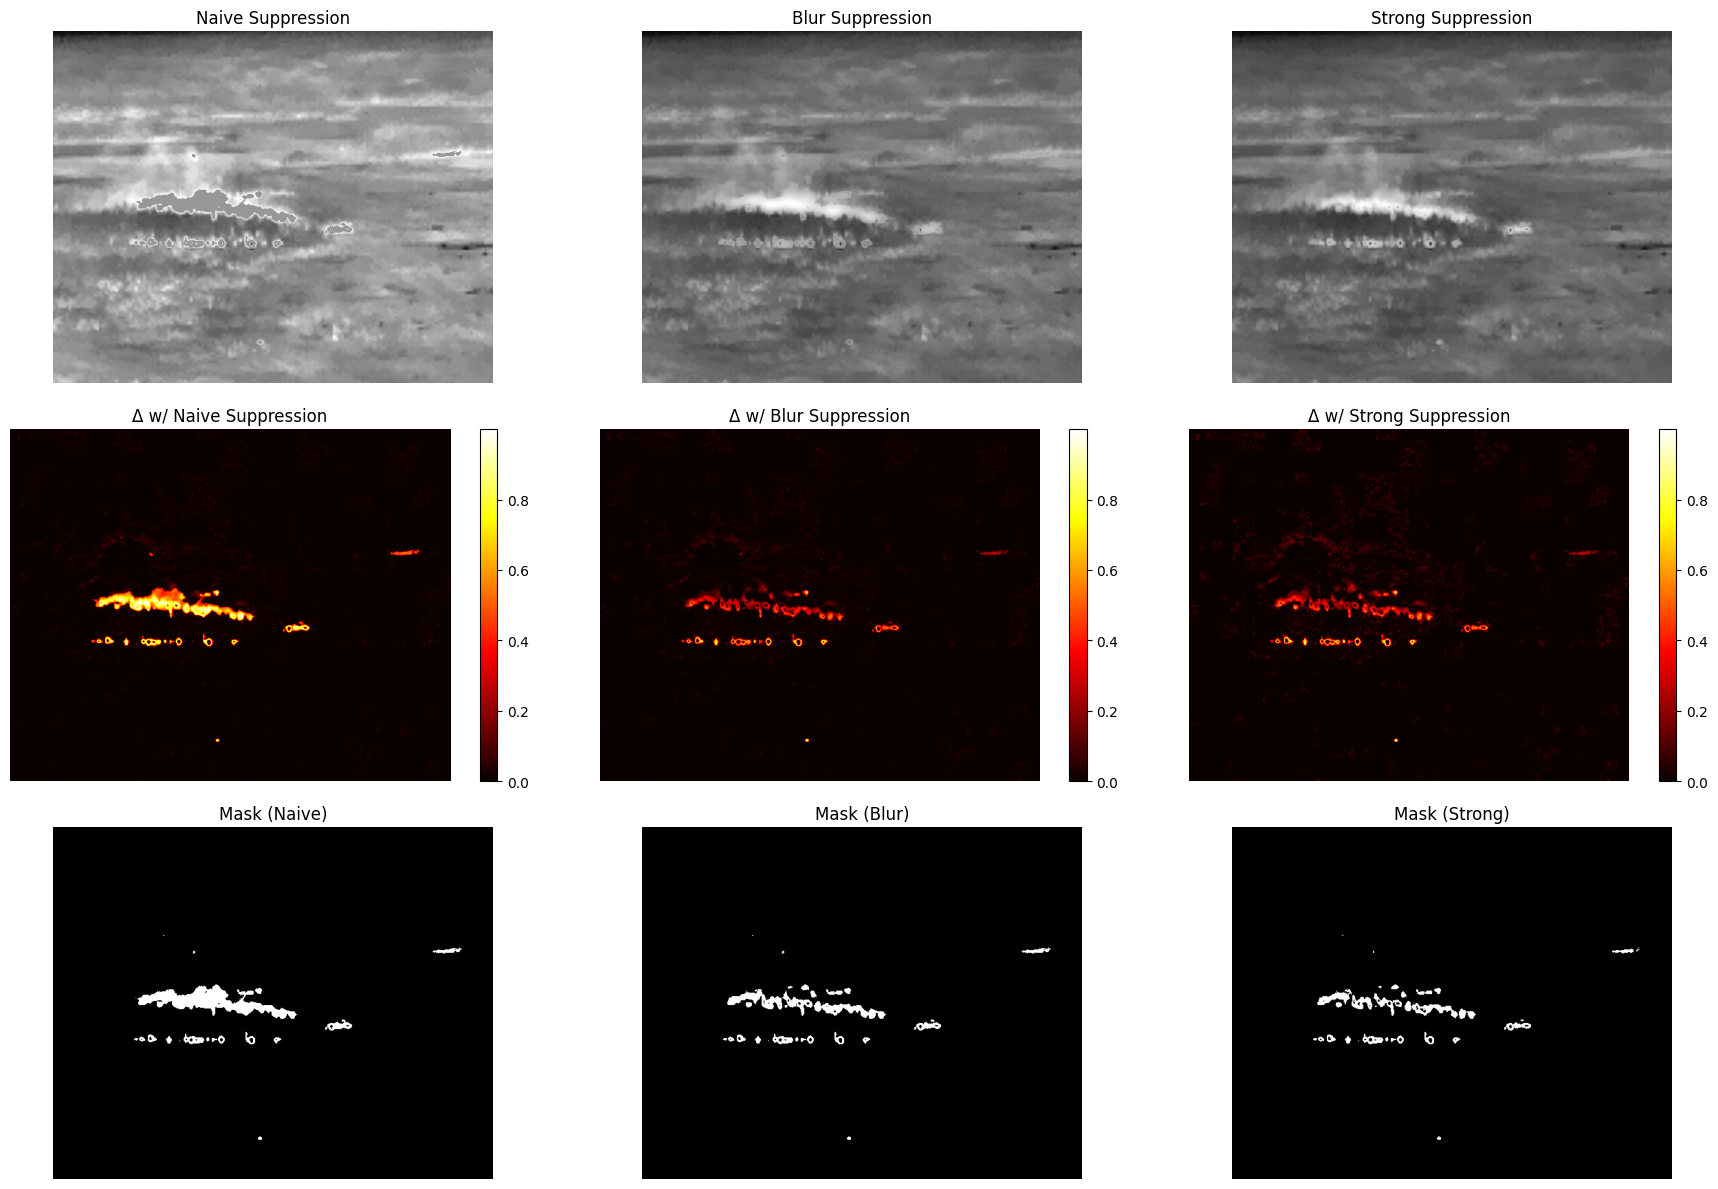

In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Suppression Methods ---
def suppress_fire_regions_naive(image, fire_threshold=50):
    fire_mask = image > (image.mean() + fire_threshold)
    suppressed = image.copy()
    suppressed[fire_mask] = image.mean()
    return suppressed, fire_mask.astype(np.uint8)

def suppress_fire_regions_with_blur(image, fire_threshold=50, blur_kernel=31):
    fire_mask = image > (image.mean() + fire_threshold)
    blurred = cv2.GaussianBlur(image, (blur_kernel, blur_kernel), 0)
    suppressed = image.copy()
    suppressed[fire_mask] = blurred[fire_mask]
    return suppressed, fire_mask.astype(np.uint8)

def suppress_fire_regions_strong(image, fire_threshold=50, blur_kernel=31, intensity_scale=0.6):
    fire_mask = image > (image.mean() + fire_threshold)
    blurred = cv2.GaussianBlur(image, (blur_kernel, blur_kernel), 0)
    suppressed = image.copy().astype(np.float32)
    suppressed[fire_mask] = (
        (1 - intensity_scale) * image[fire_mask] + intensity_scale * blurred[fire_mask]
    )
    return np.clip(suppressed, 0, 255).astype(np.uint8), fire_mask.astype(np.uint8)

# --- Difference & Mask ---
def compute_positive_difference(img1, img2):
    diff = img2 - img1
    diff[diff < 0] = 0
    return diff

def normalize_image(image):
    return (image - image.min()) / (image.max() - image.min() + 1e-5)

def threshold_difference_map(diff, diff_threshold=1, temp_reference=None, temp_threshold=None):
    mask = diff > diff_threshold
    if temp_reference is not None and temp_threshold is not None:
        temp_mask = temp_reference > (temp_reference.mean() + temp_threshold)
        mask = np.logical_and(mask, temp_mask)
    return mask.astype(np.uint8)

# --- Assuming img1, img2 are already loaded and are float32 grayscale images ---

# Apply suppression methods
img1_naive, _ = suppress_fire_regions_naive(img1, fire_threshold=50)
img1_blur, _ = suppress_fire_regions_with_blur(img1, fire_threshold=50, blur_kernel=41)
img1_strong, _ = suppress_fire_regions_strong(img1, fire_threshold=50, blur_kernel=41, intensity_scale=0.6)

# Compute differences
diff_naive = compute_positive_difference(img1_naive, img2)
diff_blur = compute_positive_difference(img1_blur, img2)
diff_strong = compute_positive_difference(img1_strong, img2)

# Normalize for visualization
norm_naive = normalize_image(diff_naive)
norm_blur = normalize_image(diff_blur)
norm_strong = normalize_image(diff_strong)

# Thresholded binary masks
mask_naive = threshold_difference_map(diff_naive, diff_threshold=10, temp_reference=img2, temp_threshold=50)
mask_blur = threshold_difference_map(diff_blur, diff_threshold=10, temp_reference=img2, temp_threshold=50)
mask_strong = threshold_difference_map(diff_strong, diff_threshold=10, temp_reference=img2, temp_threshold=50)

# --- Visualization ---
plt.figure(figsize=(18, 12))

# Row 1 – Suppressed images
plt.subplot(3, 3, 1)
plt.title("Naive Suppression")
plt.imshow(img1_naive, cmap='gray')
plt.axis('off')

plt.subplot(3, 3, 2)
plt.title("Blur Suppression")
plt.imshow(img1_blur, cmap='gray')
plt.axis('off')

plt.subplot(3, 3, 3)
plt.title("Strong Suppression")
plt.imshow(img1_strong, cmap='gray')
plt.axis('off')

# Row 2 – Difference heatmaps
plt.subplot(3, 3, 4)
plt.title("Δ w/ Naive Suppression")
plt.imshow(norm_naive, cmap='hot')
plt.colorbar()
plt.axis('off')

plt.subplot(3, 3, 5)
plt.title("Δ w/ Blur Suppression")
plt.imshow(norm_blur, cmap='hot')
plt.colorbar()
plt.axis('off')

plt.subplot(3, 3, 6)
plt.title("Δ w/ Strong Suppression")
plt.imshow(norm_strong, cmap='hot')
plt.colorbar()
plt.axis('off')

# Row 3 – Thresholded masks
plt.subplot(3, 3, 7)
plt.title("Mask (Naive)")
plt.imshow(mask_naive, cmap='gray')
plt.axis('off')

plt.subplot(3, 3, 8)
plt.title("Mask (Blur)")
plt.imshow(mask_blur, cmap='gray')
plt.axis('off')

plt.subplot(3, 3, 9)
plt.title("Mask (Strong)")
plt.imshow(mask_strong, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()
